# Rainfall across the Australian wheatbelt

The Australian Bureau of Agricultural and Resource Economics and Sciences (ABARES)
defines a set of Australian broadacre zones and regions.

The last four very dry years across the "wheat-sheep" region
line up really well with the last four times Australia had to import grain
(1994-95, 2002-03, 2006-07, 2019-20; see
[ABC](https://www.abc.net.au/news/rural/2019-05-15/australia-approves-grain-imports/11113320),
[Guardian](https://www.theguardian.com/australia-news/2019/may/15/australia-to-import-wheat-for-first-time-in-12-years-as-drought-eats-into-grain-production)).

In [1]:
import os
import sys
sys.path.append('/home/599/dbi599/unseen/unseen')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xarray as xr
import numpy as np
from dask.distributed import Client, LocalCluster
from IPython.display import Image
import cftime

import fileio
import time_utils

In [2]:
# Optional parameters 
# (This cell is tagged "parameters")

region = 'all'  # 'south-west', 'south-east', 'north-east'

In [3]:
# Parameters
agcd_file = (
    "/g/data/xv83/dbi599/ag/pr_agcd_1900-2019_A-DEC-mean_wheat-sheep-mean.zarr.zip"
)
cafe_file = "/g/data/xv83/dbi599/ag/pr_cafe-c5-d60-pX-f6_19811101-20201101_A-DEC-mean_wheat-sheep-mean.zarr.zip"
cafe_bc_file = "/g/data/xv83/dbi599/ag/pr_cafe-c5-d60-pX-f6_19900501-20191101_A-DEC-mean_wheat-sheep-mean_bias-corrected-agcd-additive.zarr.zip"
fidelity_file = "/g/data/xv83/dbi599/ag/ks-test_pr_cafe-c5-d60-pX-f6_19900501-20191101_A-DEC-mean_wheat-sheep-mean_bias-corrected-agcd-additive.zarr.zip"
independence_plot = "/g/data/xv83/dbi599/ag/independence-test_pr_cafe-c5-d60-pX-f6_19900501-20191101_A-DEC-mean_wheat-sheep-mean_bias-corrected-agcd-additive_region-all.png"
region = "all"


In [4]:
# Required parameters
assert os.path.isfile(agcd_file), "Must provide an AGCD data file (papermill option -p agcd_file [filepath])"
assert os.path.isfile(cafe_file), "Must provide an CAFE data file (papermill option -p cafe_file [filepath])"
assert os.path.isfile(cafe_bc_file), "Must provide an CAFE bias corrected data file (papermill option -p cafe_bc_file [filepath])"
assert os.path.isfile(fidelity_file), "Must provide an fidelity test file (papermill option -p fidelity_file [filepath])"
assert os.path.isfile(independence_plot), "Must provide an independence test plot (papermill option -p independence_plot [filepath])"

## Observations

In [5]:
agcd_ds = fileio.open_file(agcd_file)

In [6]:
agcd_ds

<xarray.Dataset>
Dimensions:  (region: 4, time: 120)
Coordinates:
  * region   (region) <U10 'south-west' 'south-east' 'north-east' 'all'
  * time     (time) object 1900-12-31 00:00:00 ... 2019-12-31 00:00:00
Data variables:
    pr       (time, region) float64 dask.array<chunksize=(1, 4), meta=np.ndarray>
Attributes: (12/29)
    Conventions:               CF-1.6, ACDD-1.3
    acknowledgment:            The Australian Government, Bureau of Meteorolo...
    agcd_version:              AGCD v2.0.0 Snapshot (1900-01-01 to 2020-05-31)
    analysis_components:       total: the gridded accumulation of rainfall.
    attribution:               Data should be cited as : Australian Bureau of...
    cdm_data_type:             Grid
    ...                        ...
    summary:                   The monthly rainfall data represents the amoun...
    time_coverage_end:         1900-12-31T00:00:00
    time_coverage_start:       1900-01-01T00:00:00
    title:                     Interpolated Rain Gauge Precipitation
    url:                       http://www.bom.gov.au/climate/
    uuid:                      43596dc1-c56e-42a2-ba87-4e3b726a6e60

In [7]:
agcd_ds['pr'] = agcd_ds['pr'] * 365
agcd_ds['pr'].attrs['units'] = 'mm yr-1'

In [8]:
years = agcd_ds['time'].dt.year.values
agcd_df = pd.DataFrame(index=years)
agcd_df[region] = agcd_ds['pr'].sel(region='all').values

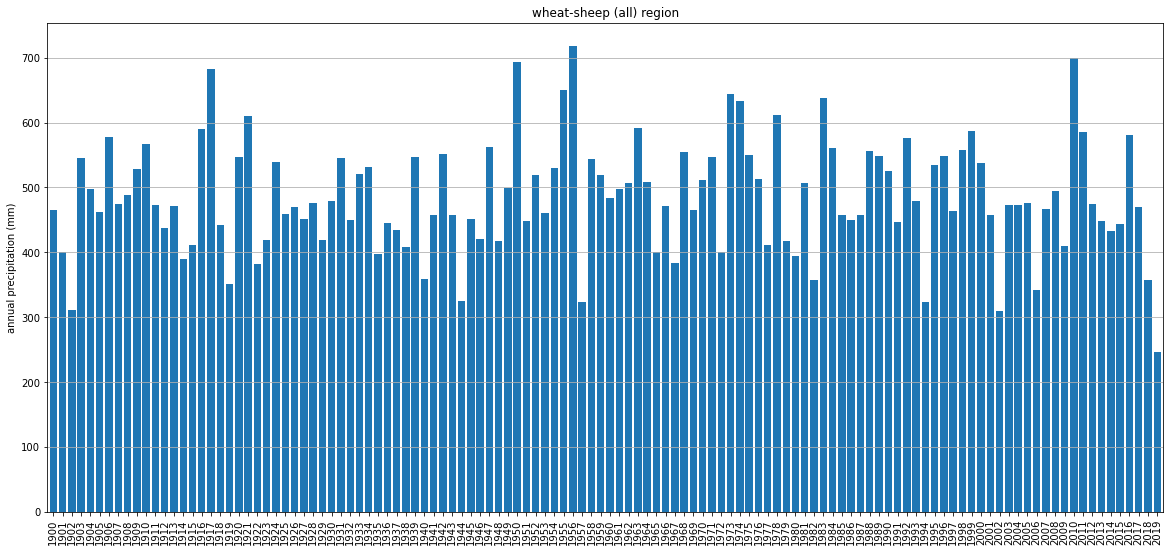

In [9]:
agcd_df[region].plot.bar(figsize=[20, 9], width=0.8)
plt.ylabel('annual precipitation (mm)')
plt.title(f'wheat-sheep ({region}) region')
plt.grid(axis='y')
plt.savefig(f'/g/data/xv83/dbi599/ag/wheat_sheep_precip_{region}.png', bbox_inches='tight', facecolor='white')
plt.show()

In [10]:
ranked_years = agcd_df['all'].sort_values()
ranked_years.head(n=10)

2019    246.779661
2002    310.594415
1902    311.070922
1994    323.246636
1957    323.559183
1944    325.085380
2006    342.297344
1919    351.863862
2018    357.549319
1982    357.924929
Name: all, dtype: float64

In [11]:
rank_2019 = ranked_years.index.get_loc(2019) + 1
rank_2006 = ranked_years.index.get_loc(2006) + 1

2019 statistics from observational record: 1 in 119 year event (i.e. 0.8% percentile, 119 year return period)

2006 statistics from observational record: 7 in 119 year event (i.e. 5.9% percentile, 17 year return period)

## Model ensemble

In [12]:
cafe_ds = fileio.open_file(cafe_file)
cafe_bc_ds = fileio.open_file(cafe_bc_file)

In [13]:
cafe_bc_ds['pr'].attrs['units']

'mm d-1'

In [14]:
cafe_ds['pr'] = cafe_ds['pr'] * 365
cafe_ds['pr'].attrs['units'] = 'mm yr-1'

cafe_bc_ds['pr'] = cafe_bc_ds['pr'] * 365
cafe_bc_ds['pr'].attrs['units'] = 'mm yr-1'

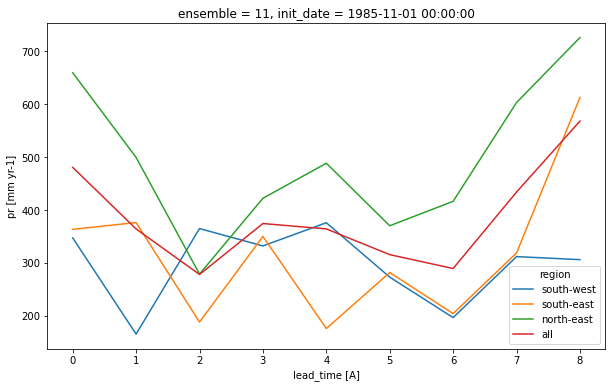

In [15]:
fig = plt.figure(figsize=[10, 6])

cafe_ds.isel(ensemble=10, init_date=5)['pr'].plot(hue='region')

plt.show()

## Bias correction and fidelity testing

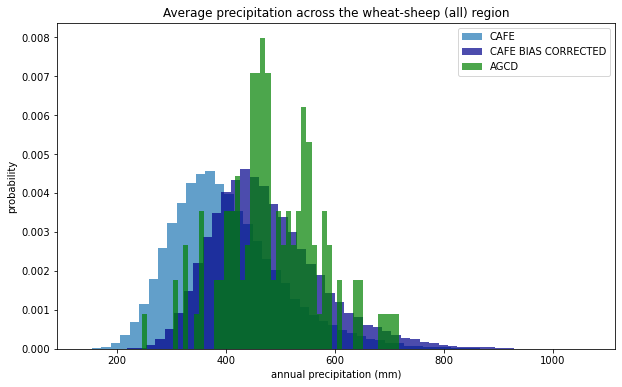

In [16]:
fig = plt.figure(figsize=[10, 6])
cafe_ds.sel(region=region)['pr'].plot.hist(bins=50, density=True, label='CAFE', alpha=0.7)
cafe_bc_ds.sel(region=region)['pr'].plot.hist(bins=50, density=True, label='CAFE BIAS CORRECTED', facecolor='darkblue', alpha=0.7)
agcd_ds.sel(region=region)['pr'].plot.hist(bins=50, density=True, label='AGCD', facecolor='green', alpha=0.7)
plt.xlabel('annual precipitation (mm)')
plt.ylabel('probability')
plt.title(f'Average precipitation across the wheat-sheep ({region}) region')
plt.legend()
plt.savefig(f'/g/data/xv83/dbi599/wheat_sheep_precip_histogram_{region}.png', bbox_inches='tight', facecolor='white')
plt.show()

In [17]:
fidelity_ds = xr.open_zarr(fidelity_file)

In [18]:
fidelity_ds.sel(region='all')['pval'].values

array([0.20819994, 0.27640568, 0.36216445, 0.23619091, 0.15059655,
       0.10878515, 0.11152911, 0.10052024, 0.08058135])

p > 0.05 at all lead times so the null hypothesis (that the two samples are from the same population) can't be rejected.

## Independence testing

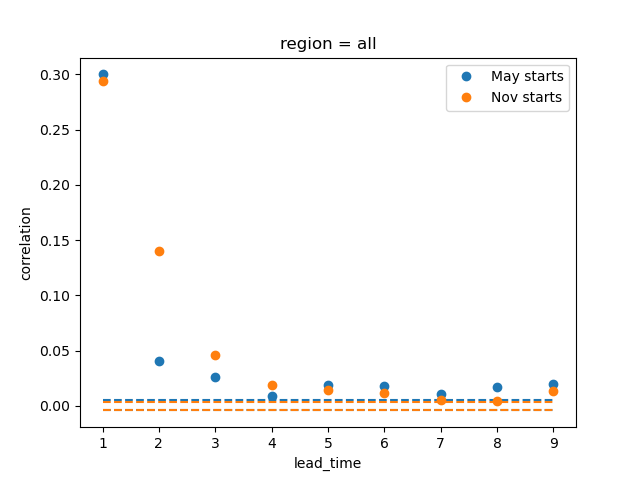

In [19]:
Image(filename=independence_plot)

## Exceedance curves

In [20]:
cafe_bc_ds_stacked = cafe_bc_ds.sel(region=region, lead_time=slice(3, None))['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [21]:
cafe_bc_ds_stacked.shape

(44928,)

In [22]:
cafe_bc_ds_stacked = time_utils.select_time_period(cafe_bc_ds_stacked, ['1990-01-01', '2019-12-31'])

In [23]:
cafe_bc_ds_stacked = cafe_bc_ds_stacked.dropna(dim='sample')

In [24]:
cafe_bc_ds_stacked.shape

(34272,)

In [25]:
def calc_exceedance(ds_stacked):
    """Calculate exceedance"""
    
    data = ds_stacked.compute()
    sorted_data = np.sort(data, axis=None)
    exceedance = 1.-np.arange(1.,len(data) + 1.)/len(data)
    
    return sorted_data, exceedance

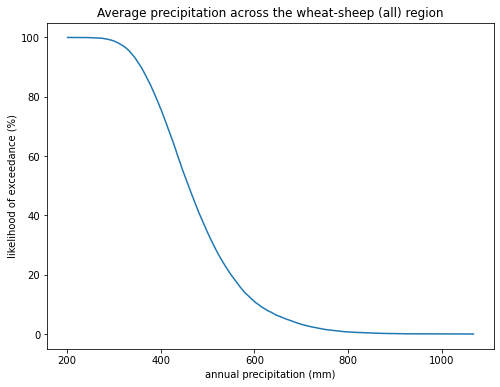

In [26]:
sorted_data, exceedance = calc_exceedance(cafe_bc_ds_stacked)

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot()
ax.plot(sorted_data, exceedance * 100)
ax.set_title(f'Average precipitation across the wheat-sheep ({region}) region')
ax.set_ylabel('likelihood of exceedance (%)')
ax.set_xlabel('annual precipitation (mm)')
plt.show()

In [27]:
def calc_likelihood(data, threshold, direction):
    """Calculate the likelihood of an event
    
    Args:
      data (np.ndarray)
      threshold (float)
      direction (str) : 'less' or 'greater' than
    """

    n_population = len(data)
    if direction == 'less':
        n_events = np.sum(data < threshold)
    elif direction == 'greater':
        n_events = np.sum(data > threshold)
    else:
        raise ValueError("""direction must be 'less' or 'greater'""")
        
    likelihood = (n_events / n_population) * 100
    
    return_period = 1 / (likelihood / 100)
    print(f'{threshold} mm: {likelihood}%, {return_period} years')
    
    return likelihood

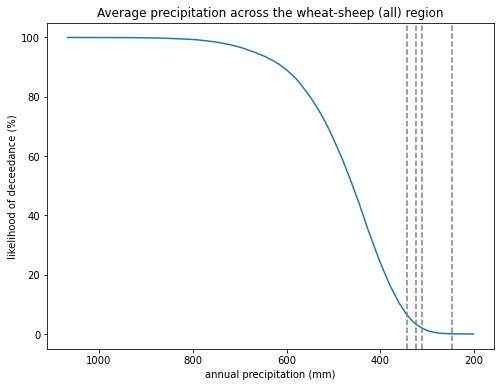

In [28]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot()
ax.plot(sorted_data, 100 - (exceedance * 100))
ax.invert_xaxis()
ax.set_title(f'Average precipitation across the wheat-sheep ({region}) region')
ax.set_ylabel('likelihood of deceedance (%)')
ax.set_xlabel('annual precipitation (mm)')
#ax.plot(244.0081797, 0, 'o')
ax.axvline(246.779661, color='0.5', linestyle='--')
ax.axvline(310.594415, color='0.5', linestyle='--')
ax.axvline(323.246636, color='0.5', linestyle='--')
ax.axvline(342.297344, color='0.5', linestyle='--')
plt.show()

1990-1999
246.779661 mm: 0.044515669515669515%, 2246.4 years
342.297344 mm: 4.923433048433049%, 20.311030741410487 years
2000-2009
246.779661 mm: 0.052083333333333336%, 1920.0 years
342.297344 mm: 6.770833333333333%, 14.76923076923077 years
2010-2019
246.779661 mm: 0.043402777777777776%, 2304.0 years
342.297344 mm: 7.013888888888889%, 14.257425742574258 years


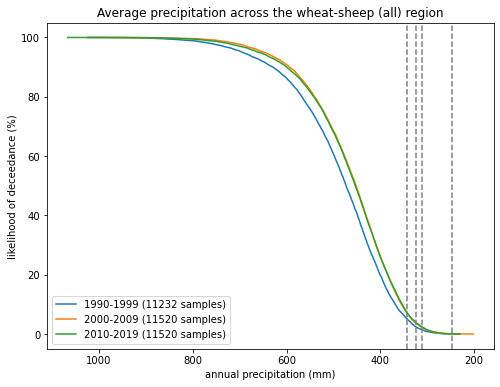

In [29]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot()

for start_year in [1990, 2000, 2010]:
    end_year = start_year + 9
    start_date = f'{start_year}-01-01'
    end_date = f'{end_year}-12-31'
    ds_selection = time_utils.select_time_period(cafe_bc_ds_stacked, [start_date, end_date])
    ds_selection = ds_selection.dropna('sample')
    sorted_data, exceedance = calc_exceedance(ds_selection)
    n_years = len(sorted_data)
    label = f'{start_year}-{end_year} ({n_years} samples)'
    ax.plot(sorted_data, 100 - (exceedance * 100), label=label)
    
    print(f'{start_year}-{end_year}')
    likelihood = calc_likelihood(ds_selection.values, 246.779661, 'less')
    likelihood = calc_likelihood(ds_selection.values, 342.297344, 'less')

ax.invert_xaxis()
ax.set_title(f'Average precipitation across the wheat-sheep ({region}) region')
ax.set_ylabel('likelihood of deceedance (%)')
ax.set_xlabel('annual precipitation (mm)')
ax.legend()
#ax.plot(244.0081797, 0, 'o')
ax.axvline(246.779661, color='0.5', linestyle='--')
ax.axvline(310.594415, color='0.5', linestyle='--')
ax.axvline(323.246636, color='0.5', linestyle='--')
ax.axvline(342.297344, color='0.5', linestyle='--')

plt.show()

NOTE: That jump from 1990-1999 to the other decades wasn't there when I only used 1990 initial dates onwards...

In [30]:
wheat_import_years = [1994, 2002, 2006, 2019]

In [31]:
for year in wheat_import_years:
    slice_start = f'{year}-01-01'
    slice_end = f'{year}-12-31'
    threshold = float(agcd_ds['pr'].sel(time=slice(slice_start, slice_end), region='all').values)
    likelihood = calc_likelihood(cafe_bc_ds_stacked.values, threshold, 'less')
    return_period = 1 / (likelihood / 100)
    print(f'{year} ({threshold} mm): {likelihood}%, {return_period} years')

323.246635948967 mm: 3.2183706816059754%, 31.07162284678151 years
1994 (323.246635948967 mm): 3.2183706816059754%, 31.07162284678151 years
310.5944147899352 mm: 1.9637021475256768%, 50.92421991084696 years
2002 (310.5944147899352 mm): 1.9637021475256768%, 50.92421991084696 years
342.29734390455957 mm: 6.247082166199814%, 16.007473143390936 years
2006 (342.29734390455957 mm): 6.247082166199814%, 16.007473143390936 years
246.77966056566456 mm: 0.04668534080298786%, 2142.0 years
2019 (246.77966056566456 mm): 0.04668534080298786%, 2142.0 years


In [32]:
np.count_nonzero(cafe_bc_ds_stacked.values < 246.779661)

16

In [33]:
(16 / 34272) * 100

0.04668534080298786

## Summary

2019 was an incredibly rare event (unpreceedented in the observational record, a 1 in 2000 year event in our large ensemble) but years sufficiently dry to require wheat imports (i.e. 2006 rainfall of 342mm) are relatively frequent (1 in 16/17 years in both the model/obs).